## Analysis of EEG_sleep.mat 

In [1]:
import scipy.io as scio
from scipy.signal import welch, get_window
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from prettytable import PrettyTable
import matplotlib.pyplot as plot

# please enter the address of input file "session4_train_2018.mat"
path = r'EEG_sleep.mat'  # PATH TO THE FILE
data = scio.loadmat(path)

/Users/pgmenon/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Wed Sep 25 17:13:29 2019',
 '__version__': '1.0',
 '__globals__': [],
 'EEG': array([[(array([[ -2.71875],
                [ -6.3125 ],
                [-11.53125],
                ...,
                [ -3.875  ],
                [ -3.78125],
                [ -3.40625]]), array([[5],
                [5],
                [5],
                ...,
                [5],
                [5],
                [5]], dtype=uint8), array([[500]], dtype=uint16))]],
       dtype=[('data', 'O'), ('labels', 'O'), ('fs', 'O')])}

In [7]:
# raw = data['EEG'][0][0][0][0]   # EXPERIMENT WITH THIS
# raw

# Extract the raw signal from data2
raw = data['EEG'][0][0][0]

# Flatten the raw signal array
raw = raw.flatten()

# Extract the sampling frequency from data2
samplingFrequency = data['EEG'][0][0][2][0][0]

print("Raw Signal:", raw)
print("Sampling Frequency:", samplingFrequency)

Raw Signal: [ -2.71875  -6.3125  -11.53125 ...  -3.875    -3.78125  -3.40625]
Sampling Frequency: 500


In [8]:
len(raw)

15390000

In [9]:
# subset raw to the first 10000 samples
raw = raw[:10000]
len(raw)

10000

/Users/pgmenon/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Text(0, 0.5, 'Amplitude')

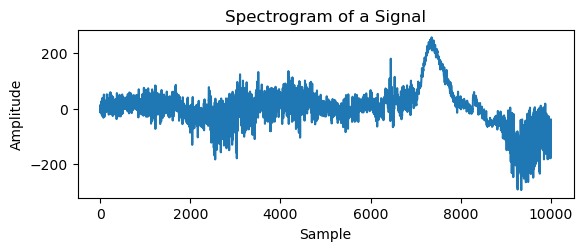

In [10]:
import pandas as pd

plot.subplot(211)
plot.title('Spectrogram of a Signal')

signal = pd.DataFrame(raw)
DF = pd.DataFrame({
    'S': signal.iloc[:,0]
})
plot.plot(DF.S)
plot.xlabel('Sample')
plot.ylabel('Amplitude')


In [11]:
# Extract the sampling frequency from data2
samplingFrequency = data['EEG'][0][0][2][0][0]
samplingFrequency

500

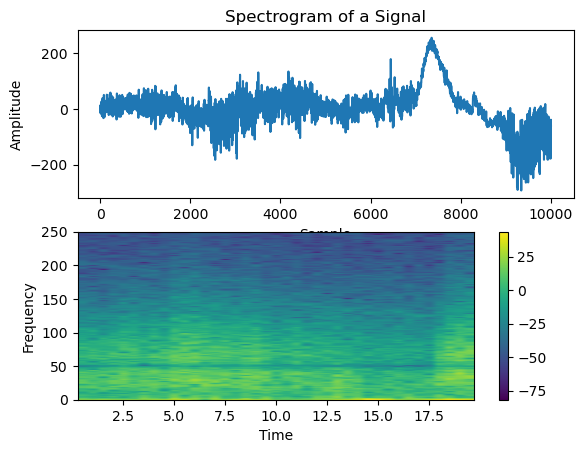

In [12]:
plot.subplot(211)
plot.title('Spectrogram of a Signal')

signal = pd.DataFrame(raw)
DF = pd.DataFrame({
    'S': signal.iloc[:,0]
})
plot.plot(DF.S)
plot.xlabel('Sample')
plot.ylabel('Amplitude')

# Compute and plot a spectrogram of data in x. Data are split into NFFT length segments and the spectrum of each section is computed.
# The windowing function window is applied to each segment, and the amount of overlap of each segment is specified with noverlap. The spectrogram is plotted as a colormap (using imshow).
plot.subplot(212)
# Changing noverlap to be an integer using integer division //
plot.specgram(DF.S,Fs=samplingFrequency,NFFT=samplingFrequency, noverlap=(samplingFrequency//2))
plot.xlabel('Time')
plot.ylabel('Frequency')

plot.colorbar()
plot.show()

## Explore the spectrogram and engineer features

In [13]:
# given DF , with a single column 'S' , and samplingFrequency, create a time axis in seconds for the signal
def time_axis(DF, samplingFrequency):
    return np.arange(0, len(DF)/samplingFrequency, 1/samplingFrequency)

DF['time'] = time_axis(DF, samplingFrequency)

DF.head()


,S,time
0,-2.71875,0.000
1,-6.31250,0.002
2,-11.53125,0.004
3,-13.46875,0.006
4,-7.75000,0.008


In [14]:
# Split the time series into windows of size NFFT=samplingFrequency, with 50% overlap i.e. (samplingFrequency//2)). Do this by creating a column with the window number for each row of the signal.

import pandas as pd

def window_number(DF, samplingFrequency):
    window_size = samplingFrequency
    step_size = samplingFrequency // 2
    num_windows = (len(DF) - step_size) // step_size + 1
    
    windows = []
    for i in range(len(DF)):
        row_windows = []
        for j in range(num_windows):
            start_idx = j * step_size
            end_idx = start_idx + window_size
            if start_idx <= i < end_idx:
                row_windows.append(j)
        windows.append(row_windows)
    
    return windows

DF['window'] = window_number(DF, samplingFrequency)


In [ ]:
# view the rows 256/2 to 256*2
# display all rows when printing in pandas
pd.set_option('display.max_rows', None)
DF.iloc[samplingFrequency//2-10:samplingFrequency*2]

In [16]:
# superimpose all the windows in a common time axis, since they are all of the same length in a plotly plot

import pandas as pd
import numpy as np
import plotly.graph_objects as go

# Assuming DF is your DataFrame and samplingFrequency is defined
def window_number(DF, samplingFrequency):
    window_size = samplingFrequency # window size is the same as NFFT
    step_size = samplingFrequency // 2  # 50% overlap
    num_windows = (len(DF) - step_size) // step_size + 1
    
    windows = []
    for i in range(len(DF)):
        row_windows = []
        for j in range(num_windows):
            start_idx = j * step_size
            end_idx = start_idx + window_size
            if start_idx <= i < end_idx:
                row_windows.append(j)
        windows.append(row_windows)
    
    return windows

DF['window'] = window_number(DF, samplingFrequency)

# Extract windows
window_size = samplingFrequency
step_size = samplingFrequency // 2
num_windows = (len(DF) - step_size) // step_size + 1

windows = []
for i in range(num_windows):
    start_idx = i * step_size
    end_idx = start_idx + window_size
    windows.append(DF.iloc[start_idx:end_idx])

# Create a common time axis
time_axis = np.arange(window_size) / samplingFrequency

# Plot using Plotly
fig = go.Figure()

for i, window in enumerate(windows):
    fig.add_trace(go.Scatter(x=time_axis, y=window['S'], mode='lines', name=f'Window {i}'))

fig.update_layout(title='Superimposed Windows on Common Time Axis',
                  xaxis_title='Time (s)',
                  yaxis_title='Signal',
                  showlegend=True)

fig.show()



## Lets engineer some frequency based features now

### Example of a spectrogram and what it means to compute power 

Text(0, 0.5, 'Amplitude')

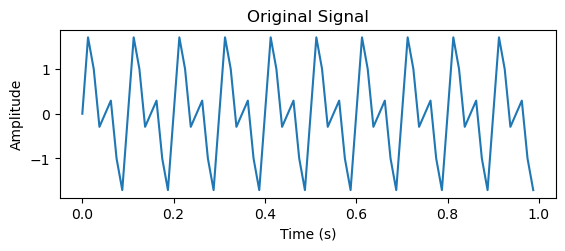

In [33]:
import numpy as np
import plotly.graph_objects as go
from scipy.signal import welch, get_window

def extract_features(segment, fs):
    window = get_window('hamming', fs)
    nfft = fs
    freq, psd = welch(segment, window=window, fs=fs, nfft=nfft)
    total_energy = np.trapz(psd, freq)
    
    delta_power = np.trapz(psd[(freq >= 1) & (freq < 4)]) / total_energy
    theta_power = np.trapz(psd[(freq >= 4) & (freq < 7)]) / total_energy
    alpha_power = np.trapz(psd[(freq >= 7) & (freq < 12)]) / total_energy
    beta_power = np.trapz(psd[(freq >= 12) & (freq < 20)]) / total_energy
    
    return freq, psd, [delta_power, theta_power, alpha_power, beta_power]

# Generate a sample signal
fs = 8  # Sampling frequency
t = np.linspace(0, 1, fs * 10, endpoint=False)  # 10 seconds of data
signal = np.sin(2 * np.pi * 10 * t) + np.sin(2 * np.pi * 20 * t)  # Example signal with 10 Hz and 20 Hz components

# Extract features and get PSD
freq, psd, features = extract_features(signal, fs)

# Create the plot
fig = go.Figure()

# Plot the PSD
fig.add_trace(go.Scatter(x=freq, y=psd, mode='lines', name='PSD'))

# Highlight the frequency bands
bands = {
    'Delta (1-4 Hz)': (1, 4),
    'Theta (4-7 Hz)': (4, 7),
    'Alpha (7-12 Hz)': (7, 12),
    'Beta (12-20 Hz)': (12, 20)
}

for band_name, (band_start, band_end) in bands.items():
    band_mask = (freq >= band_start) & (freq < band_end)
    fig.add_trace(go.Scatter(
        x=freq[band_mask], y=psd[band_mask], mode='lines', name=band_name
    ))
    
# Update layout
fig.update_layout(
    title='Power Spectral Density with Frequency Bands',
    xaxis_title='Frequency (Hz)',
    yaxis_title='Power Spectral Density (PSD)',
    legend_title='Frequency Bands'
)

# Show the plot
fig.show()



# plot the original signal in a new plot
plot.subplot(211)
plot.title('Original Signal')
plot.plot(t, signal)
plot.xlabel('Time (s)')
plot.ylabel('Amplitude')


### Lets do the same for our original signal (EEG)

In [18]:
DF.tail()

,S,time,window
9995,-63.40625,19.990,"[38, 39]"
9996,-43.09375,19.992,"[38, 39]"
9997,-38.53125,19.994,"[38, 39]"
9998,-51.84375,19.996,"[38, 39]"
9999,-59.53125,19.998,"[38, 39]"


In [ ]:
# # Extract window number, start time stamp, and end time stamp
# window_number = DF['window'].apply(lambda x: x[0])
# start_time_stamp = DF['time']
# end_time_stamp = DF['time'].shift(-1).fillna(DF['time'])

# # Create new DataFrame
# timeStampDF = pd.DataFrame({
#     'window_number': window_number,
#     'start_time_stamp': start_time_stamp,
#     'end_time_stamp': end_time_stamp
# })

# timeStampDF

In [19]:
import numpy as np
import pandas as pd
from scipy.signal import welch, get_window
from sklearn.preprocessing import normalize

def extract_features(segment, fs):
    window = get_window('hamming', fs)
    nfft = fs
    freq, psd = welch(segment, window=window, fs=fs, nfft=nfft)
    total_energy = np.trapz(psd, freq)
    
    delta_power = np.trapz(psd[(freq >= 1) & (freq < 4)]) / total_energy
    theta_power = np.trapz(psd[(freq >= 4) & (freq < 7)]) / total_energy
    alpha_power = np.trapz(psd[(freq >= 7) & (freq < 12)]) / total_energy
    beta_power = np.trapz(psd[(freq >= 12) & (freq < 20)]) / total_energy
    
    return [delta_power, theta_power, alpha_power, beta_power]

def process_segments(raw, fs, label, start, end, segment_duration):
    segments = []
    step = fs * segment_duration
    for i in range(start, end):
        segment = raw[i * step:(i + 2) * step]
        features = extract_features(segment, fs)
        features.append(label)
        segments.append(features)
    return segments

# Assuming `data` and `raw` are defined
fs = samplingFrequency
segment_duration = 1  # Duration of each segment in seconds

# Calculate the number of segments
total_segments = len(raw) // (fs * segment_duration)
start_of_seizure = int(total_segments * 12/20)

##  Based on knowledge of the ground truth of seizure labels in the dataset, we can split the segments into seizure and non-seizure segments.
# Process non-seizure segments
non_seizure_segments = process_segments(raw, fs, label=0, start=0, end=half_segments, segment_duration=segment_duration)

# Process seizure segments
seizure_segments = process_segments(raw, fs, label=1, start=seizure_segments, end=total_segments, segment_duration=segment_duration)

# Combine segments
all_segments = non_seizure_segments + seizure_segments

# Convert to DataFrame
segments_df = pd.DataFrame(all_segments, columns=['delta', 'theta', 'alpha', 'beta', 'seizure'])

# Normalize the signal data (not the ground truth labels!)
segments_df[['delta', 'theta', 'alpha', 'beta']] = normalize(segments_df[['delta', 'theta', 'alpha', 'beta']])

# Convert seizure column to category
segments_df['seizure'] = segments_df['seizure'].astype('category')

# Display DataFrame info and value counts
print(segments_df.info(verbose=True))
print(segments_df['seizure'].value_counts())

# Display the first few rows
segments_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   delta    20 non-null     float64 
 1   theta    20 non-null     float64 
 2   alpha    20 non-null     float64 
 3   beta     20 non-null     float64 
 4   seizure  20 non-null     category
dtypes: category(1), float64(4)
memory usage: 912.0 bytes
None
seizure
0    10
1    10
Name: count, dtype: int64


,delta,theta,alpha,beta,seizure
0,0.243584,0.056856,0.059212,0.966399,0
1,0.108134,0.069315,0.091085,0.987525,0
2,0.859677,0.202509,0.162757,0.439837,0
3,0.822471,0.195025,0.150846,0.512593,0
4,0.964507,0.147017,0.150627,0.159450,0


In [23]:
segments_df.to_csv('EEG_sleepMATsegments_fs_width_50pct_overlap_DTAB_GT.csv', index=False)

## Now lets do some EDA on segments_df to compare seizure and non-seizure data for each feature

In [36]:
# make plotly boxplots grouped by seizure column
import plotly.express as px

fig = px.box(segments_df, x='seizure', y='delta', points='all', title='Delta Power Distribution by Seizure Status')
fig.show()

fig = px.box(segments_df, x='seizure', y='theta', points='all', title='Theta Power Distribution by Seizure Status')
fig.show()

fig = px.box(segments_df, x='seizure', y='alpha', points='all', title='Alpha Power Distribution by Seizure Status')
fig.show()

fig = px.box(segments_df, x='seizure', y='beta', points='all', title='Beta Power Distribution by Seizure Status')
fig.show()

In [38]:
# Lets get non-parametric Mann-Whitney U test results for each feature comparing seizure and non-seizure segments

from scipy.stats import mannwhitneyu
import pandas as pd

def mannwhitneyu_test(df, feature):
    seizure = df[df['seizure'] == 1][feature]
    non_seizure = df[df['seizure'] == 0][feature]
    
    if len(seizure) == 0 or len(non_seizure) == 0:
        raise ValueError(f"One of the groups for feature '{feature}' has no observations.")
    
    stat, p = mannwhitneyu(seizure, non_seizure)
    return stat, p

features = ['delta', 'theta', 'alpha', 'beta']
results = {feature: mannwhitneyu_test(segments_df, feature) for feature in features}

results_df = pd.DataFrame(results, index=['statistic', 'p-value'])
results_df

,delta,theta,alpha,beta
statistic,2390.000000,1686.000000,984.000000,9.190000e+02
p-value,0.031132,0.188194,0.000002,3.338100e-07


In [39]:
# Lets get unpaired t-test results for each feature comparing seizure and non-seizure segments

from scipy.stats import ttest_ind
import pandas as pd

def ttest_ind_test(df, feature):
    seizure = df[df['seizure'] == 1][feature]
    non_seizure = df[df['seizure'] == 0][feature]
    
    if len(seizure) == 0 or len(non_seizure) == 0:
        raise ValueError(f"One of the groups for feature '{feature}' has no observations.")
    
    stat, p = ttest_ind(seizure, non_seizure, equal_var=False)
    return stat, p

features = ['delta', 'theta', 'alpha', 'beta']
results = {feature: ttest_ind_test(segments_df, feature) for feature in features}

results_df = pd.DataFrame(results, index=['statistic', 'p-value'])
results_df

,delta,theta,alpha,beta
statistic,1.853863,-1.307449,-4.907429,-5.105461
p-value,0.066687,0.193591,0.000005,0.000003
